<a href="https://colab.research.google.com/github/arsudheesh/brain_tumor_dataset/blob/main/brain_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required libraries **


In [1]:
import numpy as np
import pandas as pd
import os
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [2]:
!pip install kaggle

# Make sure you have your kaggle.json file uploaded to ~/.kaggle/
# Or use the Colab secrets manager to store your Kaggle API key and username
from google.colab import userdata
import os
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Replace 'dataset-owner/dataset-name' with the actual dataset path from Kaggle
!kaggle datasets download -d briscdataset/brisc2025

Dataset URL: https://www.kaggle.com/datasets/briscdataset/brisc2025
License(s): Attribution 4.0 International (CC BY 4.0)
 80% 198M/248M [00:00<00:00, 657MB/s]  
100% 248M/248M [00:00<00:00, 711MB/s]


In [3]:
import zipfile
import os

zip_file_name = 'brisc2025.zip'
if os.path.exists(zip_file_name):
    zip_ref = zipfile.ZipFile(zip_file_name, 'r')
    zip_ref.extractall()
    zip_ref.close()
    print(f"Unzipped {zip_file_name}")
else:
    print(f"Error: {zip_file_name} not found.")

Unzipped brisc2025.zip


In [4]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

image_dir = 'brisc2025/segmentation_task/train/images'
mask_dir = 'brisc2025/segmentation_task/train/masks'

data = []
folder = Path(image_dir)
for image_file in folder.glob("*.jpg"):
    mask_file = Path(mask_dir +"/"+ (image_file.stem + ".png") ) # build mask path
    if mask_file.exists():  # only add if mask exists
        data.append({
            "image_path": image_file,
            "mask_path": mask_file
        })
df = pd.DataFrame(data)

In [5]:
from PIL import Image
def display_image(image_file, mask_file):
    # Load image (grayscale)
    img = np.array(Image.open(image_file).convert("L"))

    # Load segmentation mask (binary 0/1)
    mask = np.array(Image.open(mask_file).convert("L"))
    mask = (mask > 127).astype(np.uint8)

    # Create overlay: red mask on grayscale image
    overlay = np.zeros((*img.shape, 3), dtype=np.uint8)  # RGB
    overlay[..., 0] = mask * 255   # Red channel
    overlay[..., 1] = mask * 255   # Green channel
    overlay[..., 2] = mask * 0     # Blue channel → 0 so it stays yellow

    plt.figure(figsize=(10,5))

    # Original
    plt.subplot(1,3,1)
    plt.imshow(img, cmap="gray")
    plt.title("Image")

    # Mask
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")

    # Overlay (alpha blending)
    plt.subplot(1,3,3)
    plt.imshow(img, cmap="gray")
    plt.imshow(overlay, alpha=0.4)  # alpha controls transparency
    plt.title("Image + Mask Overlay")

    plt.show()

Dataset for training 

3933
                                          image_path  \
0  brisc2025/segmentation_task/train/images/brisc...   
1  brisc2025/segmentation_task/train/images/brisc...   
2  brisc2025/segmentation_task/train/images/brisc...   
3  brisc2025/segmentation_task/train/images/brisc...   
4  brisc2025/segmentation_task/train/images/brisc...   

                                           mask_path  
0  brisc2025/segmentation_task/train/masks/brisc2...  
1  brisc2025/segmentation_task/train/masks/brisc2...  
2  brisc2025/segmentation_task/train/masks/brisc2...  
3  brisc2025/segmentation_task/train/masks/brisc2...  
4  brisc2025/segmentation_task/train/masks/brisc2...  
(3933, 2)
                                             image_path  \
1835  brisc2025/segmentation_task/train/images/brisc...   
1490  brisc2025/segmentation_task/train/images/brisc...   
2063  brisc2025/segmentation_task/train/images/brisc...   
1178  brisc2025/segmentation_task/train/images/brisc...   


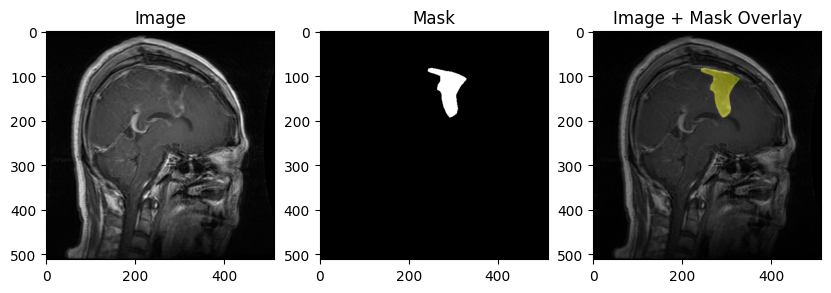

1490 brisc2025/segmentation_task/train/images/brisc2025_train_04773_pi_sa_t1.jpg brisc2025/segmentation_task/train/masks/brisc2025_train_04773_pi_sa_t1.png


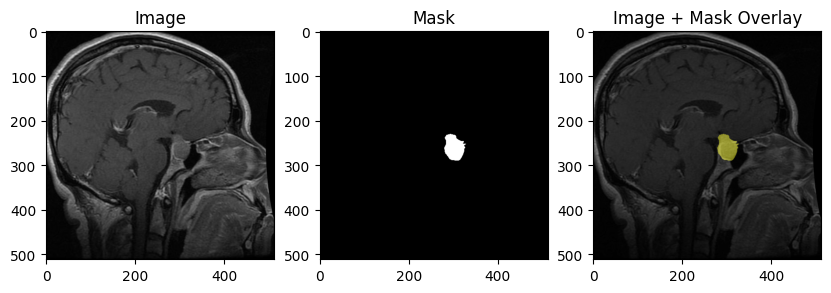

2063 brisc2025/segmentation_task/train/images/brisc2025_train_00538_gl_co_t1.jpg brisc2025/segmentation_task/train/masks/brisc2025_train_00538_gl_co_t1.png


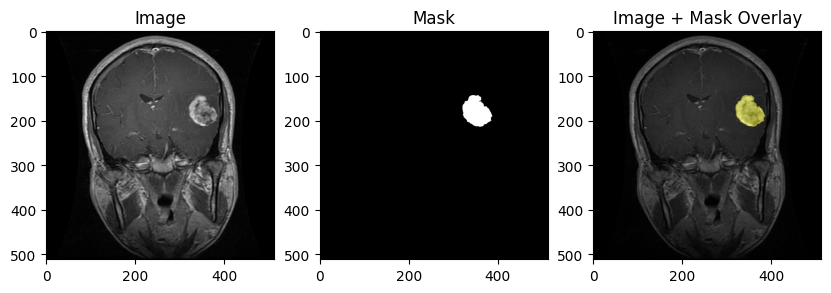

1178 brisc2025/segmentation_task/train/images/brisc2025_train_00099_gl_ax_t1.jpg brisc2025/segmentation_task/train/masks/brisc2025_train_00099_gl_ax_t1.png


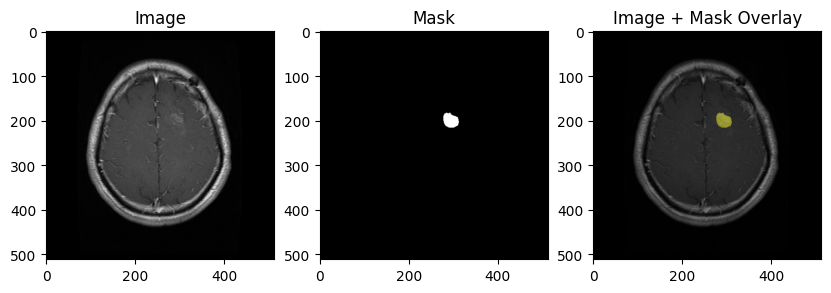

3890 brisc2025/segmentation_task/train/images/brisc2025_train_01425_me_ax_t1.jpg brisc2025/segmentation_task/train/masks/brisc2025_train_01425_me_ax_t1.png


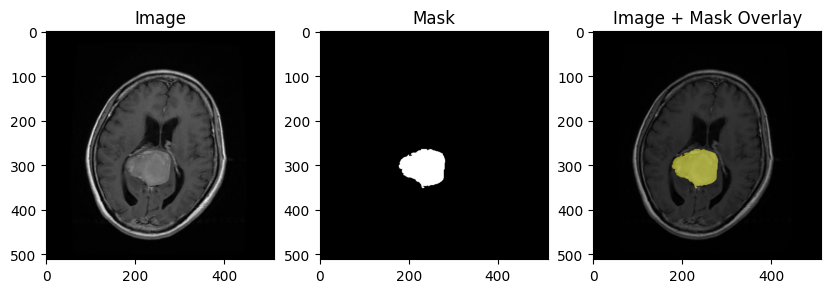

In [6]:
print('Dataset for training \n')
print(len(df))
print(df[0:5])
print(df.shape)
sampled = df.sample(n=5, random_state=42)  # random_state for reproducibility
print(sampled)
for row in sampled.itertuples(index=True):
    print(row.Index, row.image_path, row.mask_path)
    display_image(row.image_path, row.mask_path)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

In [ ]:
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, df, image_size = 256 ,transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.loc[idx, 'image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.loc[idx, 'mask_path'], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size))

        image = image.astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)

        #OpenCV loads images as [H, W, C] = (Height, Width, Channels).
        #PyTorch expects [C, H, W] = (Channels, Height, Width).
        image = np.transpose(image, (2, 0, 1))

        # Ensure tensors are contiguous
        return torch.tensor(image).contiguous(), torch.tensor(mask).unsqueeze(0).contiguous()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        preds: (N, 1, H, W) raw logits from model
        targets: (N, 1, H, W) ground truth mask {0,1}
        """
        preds = torch.sigmoid(preds)   # convert logits → probabilities
        preds = preds.view(-1)
        targets = targets.view(-1).float()

        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

        return 1 - dice  # we minimize loss, so return 1 - Dice


In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, dice_weight=1.0, bce_weight=1.0):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(weight=weight)
        self.dice = DiceLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets.float())
        dice_loss = self.dice(preds, targets)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


    A simplified U-Net architecture for binary image segmentation.

    The U-Net consists of an encoder (downsampling path),
    a bottleneck, and a decoder (upsampling path).
    Skip connections are used to concatenate feature maps from
    the encoder to the decoder, preserving spatial information.

    Encoder: Learns what a tumor looks like (edges, textures, shapes).

    Decoder: Figures out where exactly the tumor is located in the brain MRI.

    Skip connections: Ensure you don’t lose fine details of tumor boundaries when reconstructing.
    Architecture:
        - Encoder: 3 levels of convolutional blocks + max pooling
        - Bottleneck: deepest layer with highest feature channels
        - Decoder: upsampling via ConvTranspose2d + concatenation with encoder features
        - Final: 1x1 convolution to map features to binary mask

        --------------------------------------------------------------------
    Flow Diagram (example for input size 3 x 256 x 256):

        Input (B, 3, 256, 256)
            │
            ▼
        [Encoder 1] → (B, 64, 256, 256)
            │
            ▼
        MaxPool → (B, 64, 128, 128)
            │
            ▼
        [Encoder 2] → (B, 128, 128, 128)
            │
            ▼
        MaxPool → (B, 128, 64, 64)
            │
            ▼
        [Encoder 3] → (B, 256, 64, 64)
            │
            ▼
        MaxPool → (B, 256, 32, 32)
            │
            ▼
        [Bottleneck] → (B, 512, 32, 32)
            │
            ▼
        UpConv → (B, 256, 64, 64)
            + Skip from Encoder 3 → concat → (B, 512, 64, 64)
            │
            ▼
        [Decoder 3] → (B, 256, 64, 64)
            │
            ▼
        UpConv → (B, 128, 128, 128)
            + Skip from Encoder 2 → concat → (B, 256, 128, 128)
            │
            ▼
        [Decoder 2] → (B, 128, 128, 128)
            │
            ▼
        UpConv → (B, 64, 256, 256)
            + Skip from Encoder 1 → concat → (B, 128, 256, 256)
            │
            ▼
        [Decoder 1] → (B, 64, 256, 256)
            │
            ▼
        Final 1x1 Conv → (B, 1, 256, 256)
            │
            ▼
        Sigmoid → Binary Mask ∈ [0,1]

    --------------------------------------------------------------------
    Input shape:
        (B, 3, H, W)
        where B = batch size, 3 = RGB channels

    Output shape:
        (B, 1, H, W)
        where values ∈ [0, 1] (after sigmoid)

    Example:
        >>> model = UNet()
        >>> x = torch.randn(4, 3, 256, 256)  # batch of 4 RGB images
        >>> y = model(x)  
        >>> print(y.shape)  # (4, 1, 256, 256)

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        """A helper function: 2D Convolution + ReLU + 2D Convolution + ReLU"""
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU()
            )
         # Encoder (downsampling path)
        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = conv_block(256, 512)
        # Decoder (upsampling path)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Remove the sigmoid here
        return self.final(d1)

In [ ]:
def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    smooth = 1e-5
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets - preds * targets).sum(dim=(1,2,3))
    return ((intersection + 1e-5) / (union + 1e-5)).mean().item()

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback

print(f"Training on: {device}")

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_ds = BrainTumorSegmentationDataset(train_df)
val_ds = BrainTumorSegmentationDataset(val_df)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)

model = UNet() # Initialize model on CPU
model.float() # Explicitly cast model parameters to float
model.to(device) # Move model to device
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss

Training on: cuda


In [ ]:
from tqdm.notebook import tqdm  # notebook-safe progress bar
for epoch in range(10):
    print(f'Epoch {epoch} started')
    model.train()
    train_loss = 0
    pbar = tqdm(train_dl, desc=f"Epoch {epoch+1} [Training]")
    for imgs, masks in train_dl:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})


    model.eval()
    val_dice, val_iou = 0, 0
    with torch.no_grad():
        for imgs, masks in val_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)

            val_dice += dice_score(preds, masks)
            val_iou += iou_score(preds, masks)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_dl):.4f} | "
          f"Val Dice: {val_dice/len(val_dl):.4f} | Val IoU: {val_iou/len(val_dl):.4f}")


Epoch 0 started


Epoch 1 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.0145 | Val Dice: 0.7476 | Val IoU: 0.6672
Epoch 1 started


Epoch 2 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.0127 | Val Dice: 0.7495 | Val IoU: 0.6701
Epoch 2 started


Epoch 3 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.0111 | Val Dice: 0.7752 | Val IoU: 0.6895
Epoch 3 started


Epoch 4 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.0100 | Val Dice: 0.7501 | Val IoU: 0.6729
Epoch 4 started


Epoch 5 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.0095 | Val Dice: 0.7491 | Val IoU: 0.6717
Epoch 5 started


Epoch 6 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.0080 | Val Dice: 0.7818 | Val IoU: 0.7014
Epoch 6 started


Epoch 7 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.0080 | Val Dice: 0.7261 | Val IoU: 0.6513
Epoch 7 started


Epoch 8 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.0066 | Val Dice: 0.7971 | Val IoU: 0.7186
Epoch 8 started


Epoch 9 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.0063 | Val Dice: 0.7653 | Val IoU: 0.6891
Epoch 9 started


Epoch 10 [Training]:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.0070 | Val Dice: 0.7887 | Val IoU: 0.7090


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/model/brain_tumor_segmentation_model.model.20'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Mounted at /content/drive


NameError: name 'model' is not defined

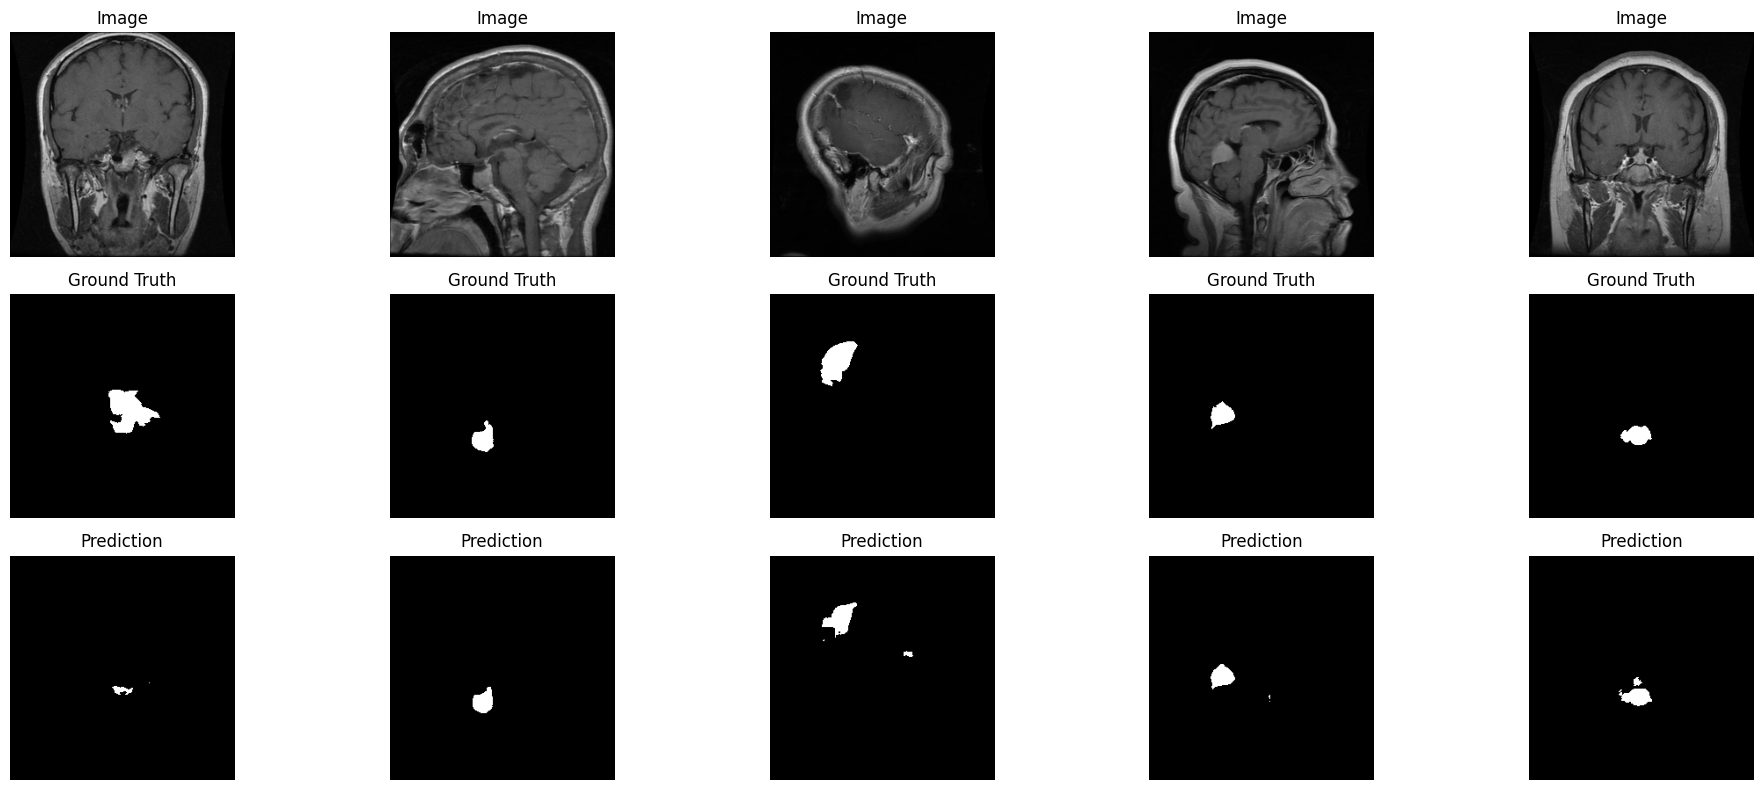

In [ ]:
model.eval()
plt.figure(figsize=(20, 8))

for i in range(5):
    image, mask = val_ds[i]
    pred = model(image.unsqueeze(0).to(device)).squeeze().detach().cpu().numpy()

    plt.subplot(3, 5, i + 1)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 5, i + 6)
    plt.imshow(mask.squeeze().numpy(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3, 5, i + 11)
    plt.imshow(pred > 0.5, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!pip install opencv-python

In [ ]:
# Save intermediate model
model_save_path = '/content/drive/My Drive/model/brain_tumor_segmentation_model.model'

# To load later:
model.load_state_dict(torch.load(model_save_path))
